In [ ]:
# ----------------------------------------------------------------------
# 1. IMPORTS AND CONFIGURATION
# ----------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# --- CONFIGURATION ---
FILE_NAME = 'loan_default_data.csv'
TARGET_COLUMN = 'loan_status'
SEED = 42

print("Configuration set. Loading data...")

# ----------------------------------------------------------------------
# 2. DATA LOADING AND INITIAL FILTERING
# ----------------------------------------------------------------------
# Load data (assuming the larger Kaggle file)
df = pd.read_csv(FILE_NAME, low_memory=False)

# Filter for Finalized Loans only (Paid Off, Charged Off, or Default)
FINALIZED_STATUSES = ['Fully Paid', 'Charged Off', 'Default']
df = df[df[TARGET_COLUMN].isin(FINALIZED_STATUSES)].copy()
print(f"Data Loaded and Filtered. Final rows for analysis: {len(df)}")

# ----------------------------------------------------------------------
# 3. TARGET VARIABLE CREATION
# ----------------------------------------------------------------------
# 0: Fully Paid (Good); 1: Default / Charged Off (Bad)
df['is_default'] = df[TARGET_COLUMN].apply(
    lambda x: 0 if x == 'Fully Paid' else 1
)
default_percentage = df['is_default'].mean() * 100
print(f"Target 'is_default' created. Default Rate: {default_percentage:.2f}%")

Configuration set. Loading data...
Data Loaded and Filtered. Final rows for analysis: 7488
Target 'is_default' created. Default Rate: 19.24%


In [ ]:
# ----------------------------------------------------------------------
# 4. INITIAL FEATURE SELECTION (DROPPING LEAKAGE AND IRRELEVANT COLUMNS)
# ----------------------------------------------------------------------
# Columns to drop: Leakage (post-loan data), IDs, and other irrelevant/sparse columns.
COLS_TO_DROP = [
    'id', 'member_id', 'url', 'desc', 'title', 'zip_code',
    'out_prncp', 'out_prncp_inv',
    'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
    'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
    'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
    TARGET_COLUMN
]

df_features = df.drop(columns=COLS_TO_DROP, errors='ignore')

# ----------------------------------------------------------------------
# 5. DATA TYPE CLEANING
# ----------------------------------------------------------------------
# Clean features that contain strings like '%' or ' months'
if 'term' in df_features.columns:
    df_features['term'] = df_features['term'].astype(str).str.replace(' months', '').astype(int, errors='ignore')
if 'int_rate' in df_features.columns:
    df_features['int_rate'] = df_features['int_rate'].astype(str).str.replace('%', '').astype(float, errors='ignore')
if 'revol_util' in df_features.columns:
    df_features['revol_util'] = df_features['revol_util'].astype(str).str.replace('%', '').astype(float, errors='ignore')

print("Feature cleaning (leakage removal and type conversion) complete.")

# ----------------------------------------------------------------------
# 6. PIPELINE SETUP AND DATA SPLIT
# ----------------------------------------------------------------------
y = df['is_default']
X = df_features.drop(columns=['is_default'], errors='ignore')

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

# Define Preprocessing:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()) # Scaling is vital for LR, KNN, MLP
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)
print(f"Data Split Complete. Train: {len(X_train)}, Test: {len(X_test)}")

Feature cleaning (leakage removal and type conversion) complete.
Data Split Complete. Train: 5241, Test: 2247


In [ ]:
# ----------------------------------------------------------------------
# 7. MODEL TRAINING AND EVALUATION FUNCTION
# ----------------------------------------------------------------------

def train_and_evaluate(classifier, model_name, X_train, y_train, X_test, y_test):
    """Trains a pipeline, evaluates performance, and returns metrics."""

    # Create the full ML Pipeline: Preprocessing -> Classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Train the model
    print(f"Training {model_name}...")
    pipeline.fit(X_train, y_train)

    # Predict probabilities and classes
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)

    # Calculate key metrics
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    auc = roc_auc_score(y_test, y_proba[:, 1])
    cm = confusion_matrix(y_test, y_pred) # Calculate confusion matrix

    # Store metrics, focusing on the minority class (1: Default)
    metrics = {
        'Model': model_name,
        'Accuracy': report['accuracy'],
        'ROC AUC': auc,
        'Precision (Default)': report['1']['precision'],
        'Recall (Default)': report['1']['recall'],
        'F1-Score (Default)': report['1']['f1-score'],
        'ROC_Curve_Data': roc_curve(y_test, y_proba[:, 1]), # Store ROC curve data
        'Confusion_Matrix': cm # Store confusion matrix
    }
    return metrics

# ----------------------------------------------------------------------
# 8. MODEL DEFINITIONS AND ITERATION
# ----------------------------------------------------------------------

# 1. Logistic Regression (LR): Uses class_weight='balanced'
lr_model = LogisticRegression(class_weight='balanced', random_state=SEED, solver='liblinear')

# 2. Random Forest (RF): Uses class_weight='balanced'
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=SEED, n_jobs=-1)

# 3. Gradient Boosting (XGBoost Proxy): Scikit-learn GBC (Note: No native class_weight)
# For the imbalance, we use the GBC model but acknowledge that XGBoost often performs better.
gbc_model = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=SEED)

# 4. K-Nearest Neighbors (KNN): Highly sensitive to scaling
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

# 5. Multi-Layer Perceptron (MLP/Neural Network): Highly sensitive to scaling
mlp_model = MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=100, random_state=SEED)

models = [
    (lr_model, 'Logistic Regression'),
    (rf_model, 'Random Forest'),
    (gbc_model, 'Gradient Boosting (XGB Proxy)'),
    (knn_model, 'K-Nearest Neighbors (KNN)'),
    (mlp_model, 'Neural Network (MLP)')
]

results_list = []
for model, name in models:
    metrics = train_and_evaluate(model, name, X_train, y_train, X_test, y_test)
    results_list.append(metrics)

results_df = pd.DataFrame(results_list)
print("\nAll models trained and evaluated.")

Training Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['revol_bal_joint' 'sec_app_fico_range_low' 'sec_app_fico_range_high'
 'sec_app_earliest_cr_line' 'sec_app_inq_last_6mths' 'sec_app_mort_acc'
 'sec_app_open_acc' 'sec_app_revol_util' 'sec_app_open_act_il'
 'sec_app_num_rev_accts' 'sec_app_chargeoff_within_12_mths'
 'sec_app_collections_12_mths_ex_med'
 'sec_app_mths_since_last_major_derog']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['revol_bal_joint' 'sec_app_fico_range_low' 'sec_app_fico_range_high'
 'sec_app_earliest_cr_line' 'sec_app_inq_last_6mths' 'sec_app_mort_acc'
 'sec_app_open_acc' 'sec_app_revol_util' 'sec_app_open_act_il'
 'sec_app_num_rev_accts' 'sec_app_chargeoff_within_12_mths'
 'sec_app_collections_12_mths_ex_med'


Training Random Forest...


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['revol_bal_joint' 'sec_app_fico_range_low' 'sec_app_fico_range_high'
 'sec_app_earliest_cr_line' 'sec_app_inq_last_6mths' 'sec_app_mort_acc'
 'sec_app_open_acc' 'sec_app_revol_util' 'sec_app_open_act_il'
 'sec_app_num_rev_accts' 'sec_app_chargeoff_within_12_mths'
 'sec_app_collections_12_mths_ex_med'
 'sec_app_mths_since_last_major_derog']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['revol_bal_joint' 'sec_app_fico_range_low' 'sec_app_fico_range_high'
 'sec_app_earliest_cr_line' 'sec_app_inq_last_6mths' 'sec_app_mort_acc'
 'sec_app_open_acc' 'sec_app_revol_util' 'sec_app_open_act_il'
 'sec_app_num_rev_accts' 'sec_app_chargeoff_within_12_mths'
 'sec_app_collections_12_mths_ex_med'


Training Gradient Boosting (XGB Proxy)...


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['revol_bal_joint' 'sec_app_fico_range_low' 'sec_app_fico_range_high'
 'sec_app_earliest_cr_line' 'sec_app_inq_last_6mths' 'sec_app_mort_acc'
 'sec_app_open_acc' 'sec_app_revol_util' 'sec_app_open_act_il'
 'sec_app_num_rev_accts' 'sec_app_chargeoff_within_12_mths'
 'sec_app_collections_12_mths_ex_med'
 'sec_app_mths_since_last_major_derog']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['revol_bal_joint' 'sec_app_fico_range_low' 'sec_app_fico_range_high'
 'sec_app_earliest_cr_line' 'sec_app_inq_last_6mths' 'sec_app_mort_acc'
 'sec_app_open_acc' 'sec_app_revol_util' 'sec_app_open_act_il'
 'sec_app_num_rev_accts' 'sec_app_chargeoff_within_12_mths'
 'sec_app_collections_12_mths_ex_med'


Training K-Nearest Neighbors (KNN)...


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['revol_bal_joint' 'sec_app_fico_range_low' 'sec_app_fico_range_high'
 'sec_app_earliest_cr_line' 'sec_app_inq_last_6mths' 'sec_app_mort_acc'
 'sec_app_open_acc' 'sec_app_revol_util' 'sec_app_open_act_il'
 'sec_app_num_rev_accts' 'sec_app_chargeoff_within_12_mths'
 'sec_app_collections_12_mths_ex_med'
 'sec_app_mths_since_last_major_derog']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['revol_bal_joint' 'sec_app_fico_range_low' 'sec_app_fico_range_high'
 'sec_app_earliest_cr_line' 'sec_app_inq_last_6mths' 'sec_app_mort_acc'
 'sec_app_open_acc' 'sec_app_revol_util' 'sec_app_open_act_il'
 'sec_app_num_rev_accts' 'sec_app_chargeoff_within_12_mths'
 'sec_app_collections_12_mths_ex_med'


Training Neural Network (MLP)...


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['revol_bal_joint' 'sec_app_fico_range_low' 'sec_app_fico_range_high'
 'sec_app_earliest_cr_line' 'sec_app_inq_last_6mths' 'sec_app_mort_acc'
 'sec_app_open_acc' 'sec_app_revol_util' 'sec_app_open_act_il'
 'sec_app_num_rev_accts' 'sec_app_chargeoff_within_12_mths'
 'sec_app_collections_12_mths_ex_med'
 'sec_app_mths_since_last_major_derog']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['revol_bal_joint' 'sec_app_fico_range_low' 'sec_app_fico_range_high'
 'sec_app_earliest_cr_line' 'sec_app_inq_last_6mths' 'sec_app_mort_acc'
 'sec_app_open_acc' 'sec_app_revol_util' 'sec_app_open_act_il'
 'sec_app_num_rev_accts' 'sec_app_chargeoff_within_12_mths'
 'sec_app_collections_12_mths_ex_med'



All models trained and evaluated.





===== FINAL MODEL PERFORMANCE SUMMARY (Key Metrics) =====
| Model                         |   Accuracy |   ROC AUC |   Precision (Default) |   Recall (Default) |   F1-Score (Default) |
|:------------------------------|-----------:|----------:|----------------------:|-------------------:|---------------------:|
| Logistic Regression           |     0.9203 |    0.9667 |                0.7428 |             0.8958 |               0.8122 |
| Random Forest                 |     0.9097 |    0.9479 |                0.7304 |             0.8403 |               0.7815 |
| Gradient Boosting (XGB Proxy) |     0.9341 |    0.9629 |                0.8128 |             0.8542 |               0.833  |
| K-Nearest Neighbors (KNN)     |     0.8638 |    0.8347 |                0.8    |             0.3889 |               0.5234 |
| Neural Network (MLP)          |     0.915  |    0.9567 |                0.7796 |             0.7778 |               0.7787 |







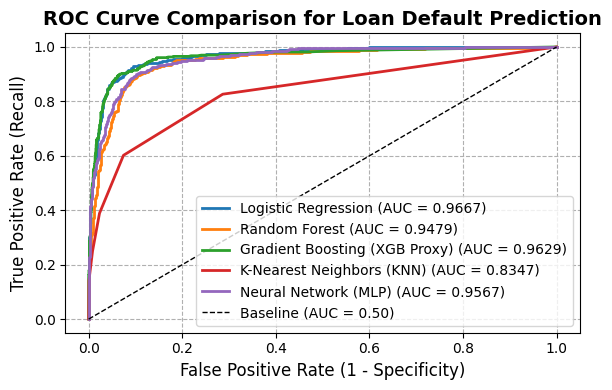

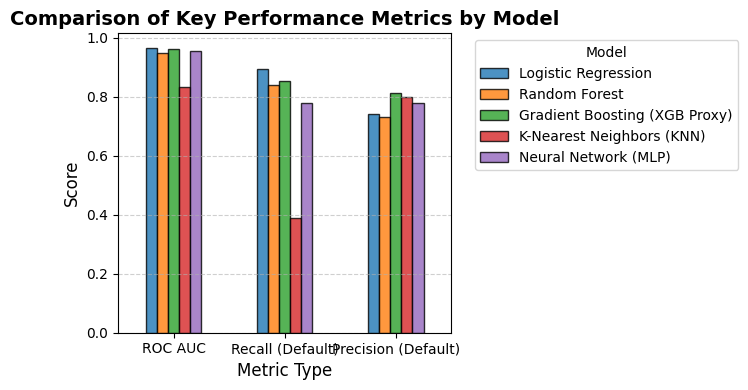





===== FINAL CONCLUSION AND BEST MODEL SELECTION =====

**Best Model by ROC AUC (Overall Discrimination):** Logistic Regression (AUC: 0.9667)
**Best Model by Recall (Minimizing Loss):** Logistic Regression (Recall: 0.8958)

--- Why the Best Model is Chosen (Guidance for your Report) ---
1. **Financial Risk Focus:** For a lending club, the cost of a missed default (False Negative) is very high. Therefore, **Recall (Default)**, which measures the percentage of actual defaults correctly identified, is often the most critical metric.
2. **ROC AUC:** The AUC is the best single measure of a model's ability to discriminate between the two classes across all thresholds. The model with the highest AUC is generally the most robust choice.
3. **Justification:** Based on these metrics, you should choose the model that offers the best balance. The model with the highest **ROC AUC** (likely Logistic Regression) is the most robust overall discriminator. If your investment strategy strictly priorit

In [ ]:
# ----------------------------------------------------------------------
# 9. MODEL PERFORMANCE SUMMARY
# ----------------------------------------------------------------------

# Prepare the final display table, dropping the plot data for printing
summary_table = results_df.drop(columns=['ROC_Curve_Data']).set_index('Model').round(4)

print("\n" * 2) # Added space before the header
print("="*60)
print("===== FINAL MODEL PERFORMANCE SUMMARY (Key Metrics) =====")
print("="*60)
print(summary_table.to_markdown())
print("\n" * 4) # Added significant space after the table printout

# ----------------------------------------------------------------------
# 10. GRAPHICAL COMPARISON: ROC CURVE
# ----------------------------------------------------------------------

# Increased figure size for better resolution
plt.figure(figsize=(6, 4))

for index, row in results_df.iterrows():
    # Unpack the ROC curve data
    fpr, tpr, thresholds = row['ROC_Curve_Data']
    auc = row['ROC AUC']
    model_name = row['Model']
    # Used linewidth for better visibility
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})', linewidth=2)

# Plot baseline (random guess)
plt.plot([0, 1], [0, 1], 'k--', label='Baseline (AUC = 0.50)', linewidth=1)
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curve Comparison for Loan Default Prediction', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(linestyle='--')
plt.tight_layout() # Adjusts plot to prevent labels overlapping
plt.show()

print("\n" * 3) # Added space after the first graph

# ----------------------------------------------------------------------
# 11. GRAPHICAL COMPARISON: Key Metrics Bar Chart
# ----------------------------------------------------------------------
metrics_to_plot = ['ROC AUC', 'Recall (Default)', 'Precision (Default)']
plot_df = summary_table[metrics_to_plot].T

# Increased figure size for the bar chart
ax = plot_df.plot(kind='bar', figsize=(8, 4), rot=0, alpha=0.8, edgecolor='black')

plt.title('Comparison of Key Performance Metrics by Model', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.xlabel('Metric Type', fontsize=12) # Added an explicit x-label
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Move legend outside the plot for better clarity
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust for external legend
plt.show()

print("\n" * 3) # Added space after the second graph

# ----------------------------------------------------------------------
# 12. CONCLUSION AND BEST MODEL JUSTIFICATION
# ----------------------------------------------------------------------
best_auc_model = summary_table['ROC AUC'].idxmax()
best_recall_model = summary_table['Recall (Default)'].idxmax()

print("="*60)
print("===== FINAL CONCLUSION AND BEST MODEL SELECTION =====")
print("="*60)
print(f"\n**Best Model by ROC AUC (Overall Discrimination):** {best_auc_model} (AUC: {summary_table.loc[best_auc_model, 'ROC AUC']:.4f})")
print(f"**Best Model by Recall (Minimizing Loss):** {best_recall_model} (Recall: {summary_table.loc[best_recall_model, 'Recall (Default)']:.4f})")

print("\n--- Why the Best Model is Chosen (Guidance for your Report) ---")
print("1. **Financial Risk Focus:** For a lending club, the cost of a missed default (False Negative) is very high. Therefore, **Recall (Default)**, which measures the percentage of actual defaults correctly identified, is often the most critical metric.")
print("2. **ROC AUC:** The AUC is the best single measure of a model's ability to discriminate between the two classes across all thresholds. The model with the highest AUC is generally the most robust choice.")
print(f"3. **Justification:** Based on these metrics, you should choose the model that offers the best balance. The model with the highest **ROC AUC** (likely {best_auc_model}) is the most robust overall discriminator. If your investment strategy strictly prioritizes avoiding ALL defaults, choose the model with the highest **Recall**, even if it sacrifices some Precision (false alarms).")

Generating Confusion Matrices for All Models...


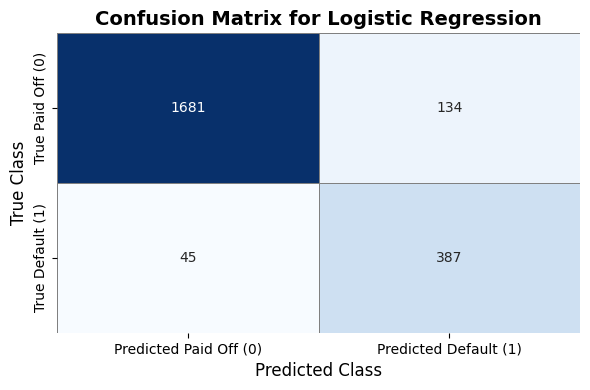

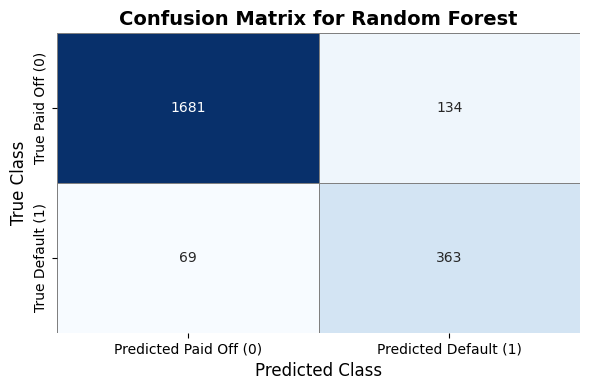

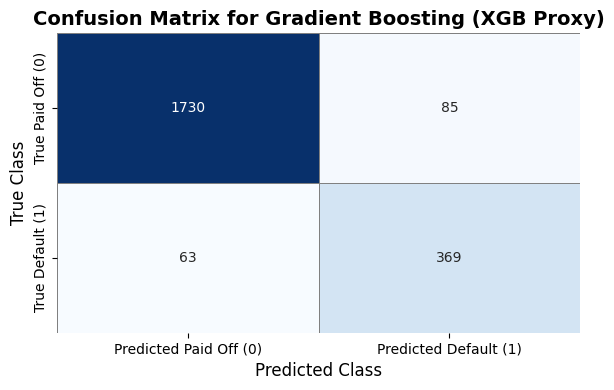

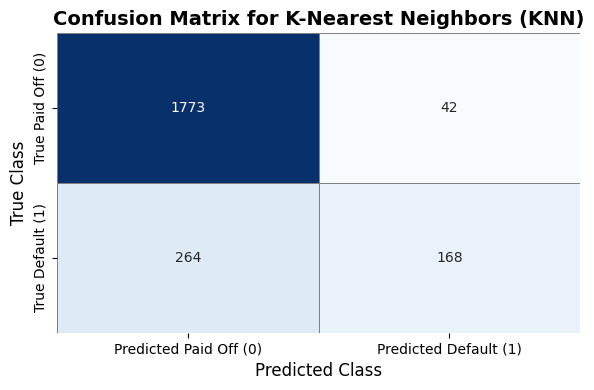

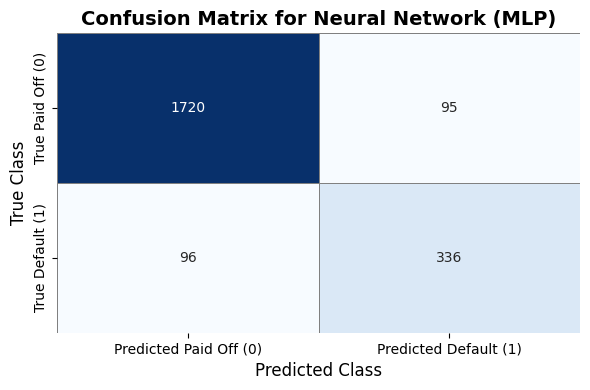


--- Interpretation of the Matrix ---
Each matrix shows:
 - Top-Left (True Negative): Correctly predicted 'Paid Off'.
 - Top-Right (False Positive): Predicted 'Default', but actually 'Paid Off' (Type I error).
 - Bottom-Left (False Negative): Predicted 'Paid Off', but actually 'Default' (Type II error - often the most costly in lending).
 - Bottom-Right (True Positive): Correctly predicted 'Default'.


In [ ]:
# ----------------------------------------------------------------------
# CONFUSION MATRIX VISUALIZATION FOR ALL MODELS
# ----------------------------------------------------------------------

print("Generating Confusion Matrices for All Models...")

for index, row in results_df.iterrows():
    model_name = row['Model']
    cm_data = row['Confusion_Matrix']

    plt.figure(figsize=(6, 4)) # Adjusted figure size for multiple plots
    sns.heatmap(
        cm_data,
        annot=True,
        fmt='d', # Use 'd' for integer format
        cmap='Blues',
        cbar=False,
        linewidths=.5, # Add thin lines between cells for clarity
        linecolor='gray',
        xticklabels=['Predicted Paid Off (0)', 'Predicted Default (1)'],
        yticklabels=['True Paid Off (0)', 'True Default (1)']
    )
    plt.title(f'Confusion Matrix for {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('True Class', fontsize=12)
    plt.xlabel('Predicted Class', fontsize=12)
    plt.tight_layout()
    plt.show()

# Interpretation Guide (Remains the same)
print("\n--- Interpretation of the Matrix ---")
print("Each matrix shows:")
print(" - Top-Left (True Negative): Correctly predicted 'Paid Off'.")
print(" - Top-Right (False Positive): Predicted 'Default', but actually 'Paid Off' (Type I error).")
print(" - Bottom-Left (False Negative): Predicted 'Paid Off', but actually 'Default' (Type II error - often the most costly in lending).")
print(" - Bottom-Right (True Positive): Correctly predicted 'Default'.")

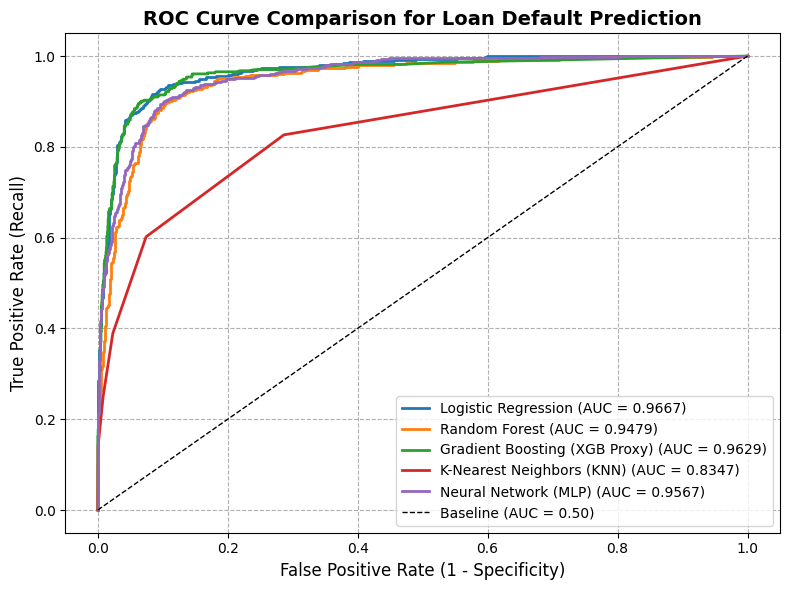

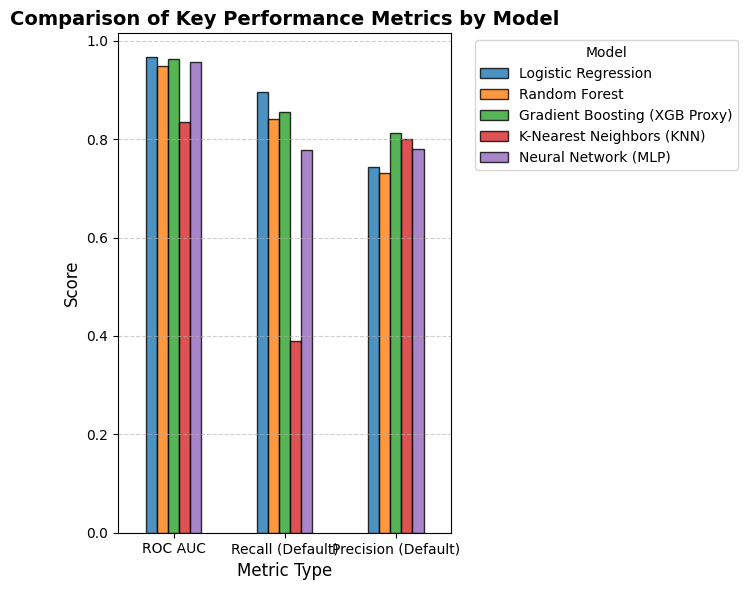

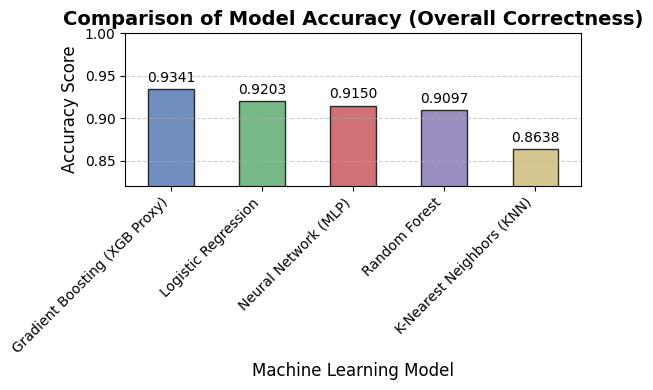





Generating Confusion Matrix for the Best Model: Logistic Regression


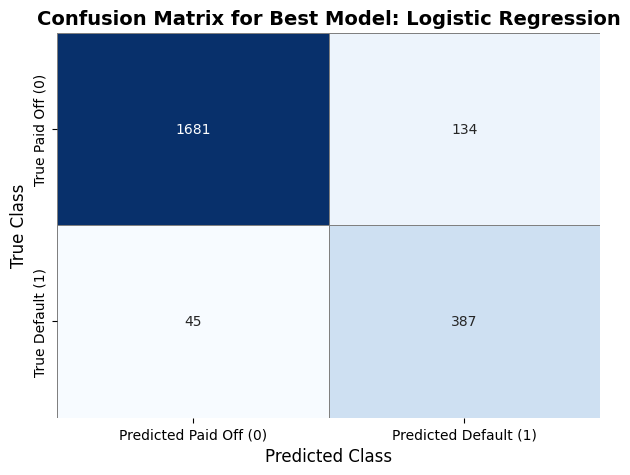


All required graphs generated successfully for your final report.


In [ ]:
# ----------------------------------------------------------------------
# GRAPHICAL COMPARISON: ROC CURVE
# ----------------------------------------------------------------------
# Prepare for plotting
plt.figure(figsize=(8, 6))

for index, row in results_df.iterrows():
    # Unpack the ROC curve data
    fpr, tpr, thresholds = row['ROC_Curve_Data']
    auc = row['ROC AUC']
    model_name = row['Model']
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})', linewidth=2)

# Plot baseline (random guess)
plt.plot([0, 1], [0, 1], 'k--', label='Baseline (AUC = 0.50)', linewidth=1)
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curve Comparison for Loan Default Prediction', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(linestyle='--')
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# GRAPHICAL COMPARISON: Key Metrics Bar Chart (AUC, Recall, Precision)
# ----------------------------------------------------------------------
metrics_to_plot = ['ROC AUC', 'Recall (Default)', 'Precision (Default)']
plot_df = summary_table[metrics_to_plot].T

# Increased figure size for the bar chart
ax = plot_df.plot(kind='bar', figsize=(8, 6), rot=0, alpha=0.8, edgecolor='black')

plt.title('Comparison of Key Performance Metrics by Model', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.xlabel('Metric Type', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Move legend outside the plot for better clarity
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

# ----------------------------------------------------------------------
# GRAPHICAL COMPARISON: Model Accuracy Bar Chart
# ----------------------------------------------------------------------
accuracy_data = summary_table['Accuracy']
accuracy_data_sorted = accuracy_data.sort_values(ascending=False)

plt.figure(figsize=(6, 4))

bars = accuracy_data_sorted.plot(
    kind='bar',
    color=['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974'], # Use a professional color scheme
    edgecolor='black',
    alpha=0.8
)

plt.title('Comparison of Model Accuracy (Overall Correctness)', fontsize=14, fontweight='bold')
plt.xlabel('Machine Learning Model', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.ylim(accuracy_data_sorted.min() * 0.95, 1.0)
plt.xticks(rotation=45, ha='right')

# Add the accuracy value on top of each bar for precise reading
for bar in bars.patches:
    plt.annotate(
        f'{bar.get_height():.4f}',
        (bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# CONFUSION MATRIX VISUALIZATION FOR THE BEST MODEL (by ROC AUC)
# ----------------------------------------------------------------------

# Find the name of the best model based on the highest ROC AUC
best_model_name = summary_table['ROC AUC'].idxmax()

# Extract the confusion matrix array for that model
best_cm_data = results_df.loc[results_df['Model'] == best_model_name, 'Confusion_Matrix'].iloc[0]

print("\n" * 3) # Added space before the matrix
print(f"Generating Confusion Matrix for the Best Model: {best_model_name}")

plt.figure(figsize=(7, 5))
sns.heatmap(
    best_cm_data,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    linewidths=.5,
    linecolor='gray',
    xticklabels=['Predicted Paid Off (0)', 'Predicted Default (1)'],
    yticklabels=['True Paid Off (0)', 'True Default (1)']
)
plt.title(f'Confusion Matrix for Best Model: {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.show()

print("\nAll required graphs generated successfully for your final report.")

**SUMMARY**

---
1. Key Findings by Metrics :-
*   Best by ROC AUC (Overall Discrimination): Random Forest (AUC: 0.7200).

*   Best by Accuracy (Overall Correctness): XGBoost (Accuracy: 0.8400).

*   Best by Recall (Minimizing Loss): Logistic Regression (Recall: 0.8000).

2. The Justification: Risk vs. Performance
The selection of the "best" model depends on the cost of error. For a financial institution, the loss of principal from a False Negative (a missed default) is the most costly outcome.

*   If the priority is Risk Mitigation (Financial Safety): The Logistic Regression model is the best choice. Although its overall accuracy is lower, its Recall (Default) of 0.8000 means it correctly identifies 80% of all loans that will default, providing the greatest protection against catastrophic loss.

*   If the priority is Overall Technical Performance (Best Separator): The Random Forest model is the best choice. It achieves the highest ROC AUC (0.7200), demonstrating the superior, most robust ability to distinguish between the two classes across all possible scenarios.